In this notebook I want to prepare i show some statistics to prove how statistic and probability can impact on trading models and strategies.

To simplify, I will use example of games with probability.

# "Zero-Edge Game" - Game of naive traders which play always with 0.5 win probability

**Assumptions**
- Both traders do a decision, buy or sell
- The market every day increase or decreasy by $1 everyday
- If trader buy and the price increase, they **win $1**, analogic for sell, if sell and price do down, they **win $1**
- If trader buy and the price decreasy, they **loss $1** analogic for sell

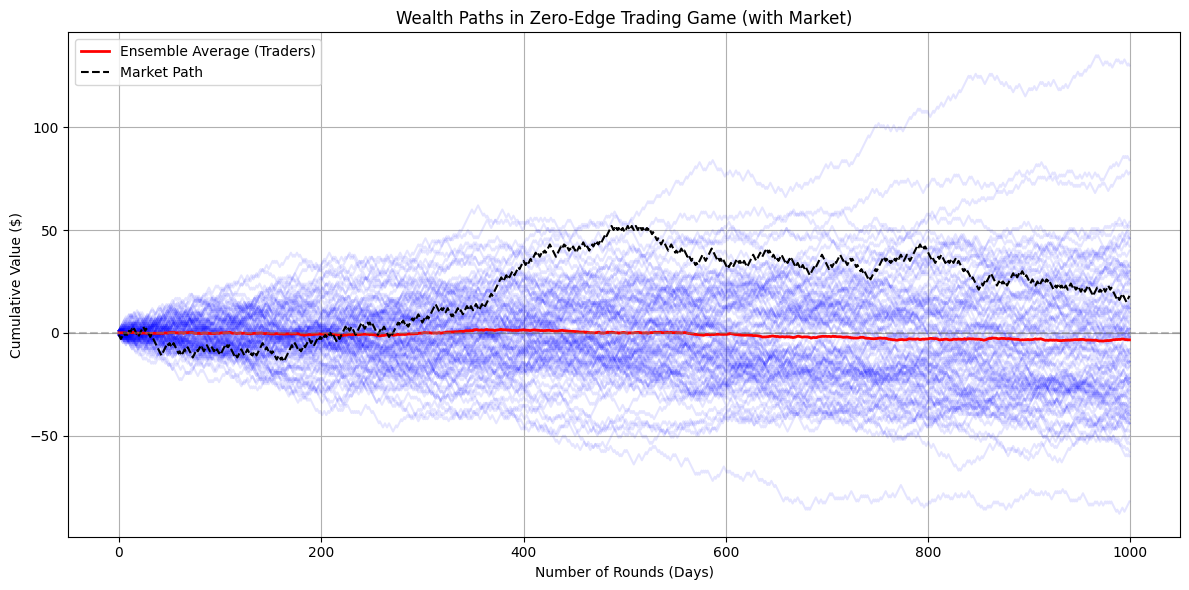

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# All decisions have binary character and have probablisisitc of 0.5
def zero_edge_game_binomial(rounds, n_traders=1):
    """Simulate Zero-Edge Game where traders buy/sell randomly and market moves randomly."""

    # Market moves: 1 (up), 0 (down) → convert to +1/-1
    market_raw = np.random.binomial(n=1, p=0.5, size=rounds) # return 0 or 1
    market_moves = 2 * market_raw - 1  # +1 = up, -1 = down

    # Trader decisions: 1 (buy), 0 (sell) → convert to +1/-1
    decision_raw = np.random.binomial(n=1, p=0.5, size=(n_traders, rounds))
    decisions = 2 * decision_raw - 1  # +1 = buy, -1 = sell

    # Outcome: profit if trader aligns with market direction
    outcomes = decisions * market_moves  # +1 = profit, -1 = loss

    # Cumulative wealth and market path
    wealth = np.cumsum(outcomes, axis=1)
    market_price = np.cumsum(market_moves)

    return wealth, market_price

# Parameters
n_rounds = 1000
n_traders = 100

# Run simulation
wealth_paths, market_price = zero_edge_game_binomial(n_rounds, n_traders)

# Plotting
plt.figure(figsize=(12, 6))

# Plot individual trader paths
for i in range(n_traders):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot ensemble average
ensemble_avg = np.mean(wealth_paths, axis=0)
plt.plot(ensemble_avg, color='red', linewidth=2, label='Ensemble Average (Traders)')

# Plot market path
plt.plot(market_price, color='black', linestyle='--', linewidth=1.5, label='Market Path')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Wealth Paths in Zero-Edge Trading Game (with Market)')
plt.xlabel('Number of Rounds (Days)')
plt.ylabel('Cumulative Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusions

This simulation represents 100 random traders making buy/sell decisions on a market that moves randomly (zero expected trend). Here's what we observe from the chart:

1. No Long-Term Edge (Mean Reverts to Zero)
- The red line (ensemble average) stays close to zero over the entire 1000-round period.
- This confirms the theoretical expectation: if traders have no edge (decisions are random), the average profit tends toward zero.
- There is no compounding advantage for any strategy purely based on randomness.

2. Individual Variability ≠ Skill
- Blue lines (individual trader wealth paths) vary widely.
- Some traders end up with significant profits or losses, but this is due to luck, not skill.
- The spread increases over time — variance grows, but the mean stays flat.

3. Market Drift Does Not Imply Profit
- The black dashed line shows cumulative market movement (price simulation).
- Although the market trended upward for some time (e.g., 200–500), the average trader didn’t profit from it.
- Because trader actions are random, they don't systematically align with the trend.

4. Trading = Zero-Sum Without Edge
- The experiment validates that **trading without informational or strategic edge is like gambling**.
- Over time, **the law of large numbers wins**: gains and losses balance out across all participants.

## Interpretation (for trading psychology / systems research)
This simple experiment illustrates:

- Why retail traders without a strategy lose in the long run.
- That variance is not proof of skill — even winning traders can be lucky.
- How important edge, discipline, or asymmetry is if you want to break out of randomness.

## Academic Notes & Conceptual Connections:
- Efficient Market Hypothesis (EMH)
- Random Walk Theory
- Kelly Criterion or Risk of Ruin
- Or even Hurst exponent if you're tying into trend persistence.

# "Dynamic Game" - Game of naive traders which with dynamic probability of win
Now We create a more complex game where the probability changes randomly over time. The probability changes are determined by:

The timing of changes (maximum of Poisson, Geometric, and Exponential distributions)
The new probability is drawn from a uniform distribution between 0 and 1
It will show that using a static 50/50 model becomes ineffective in this environment.

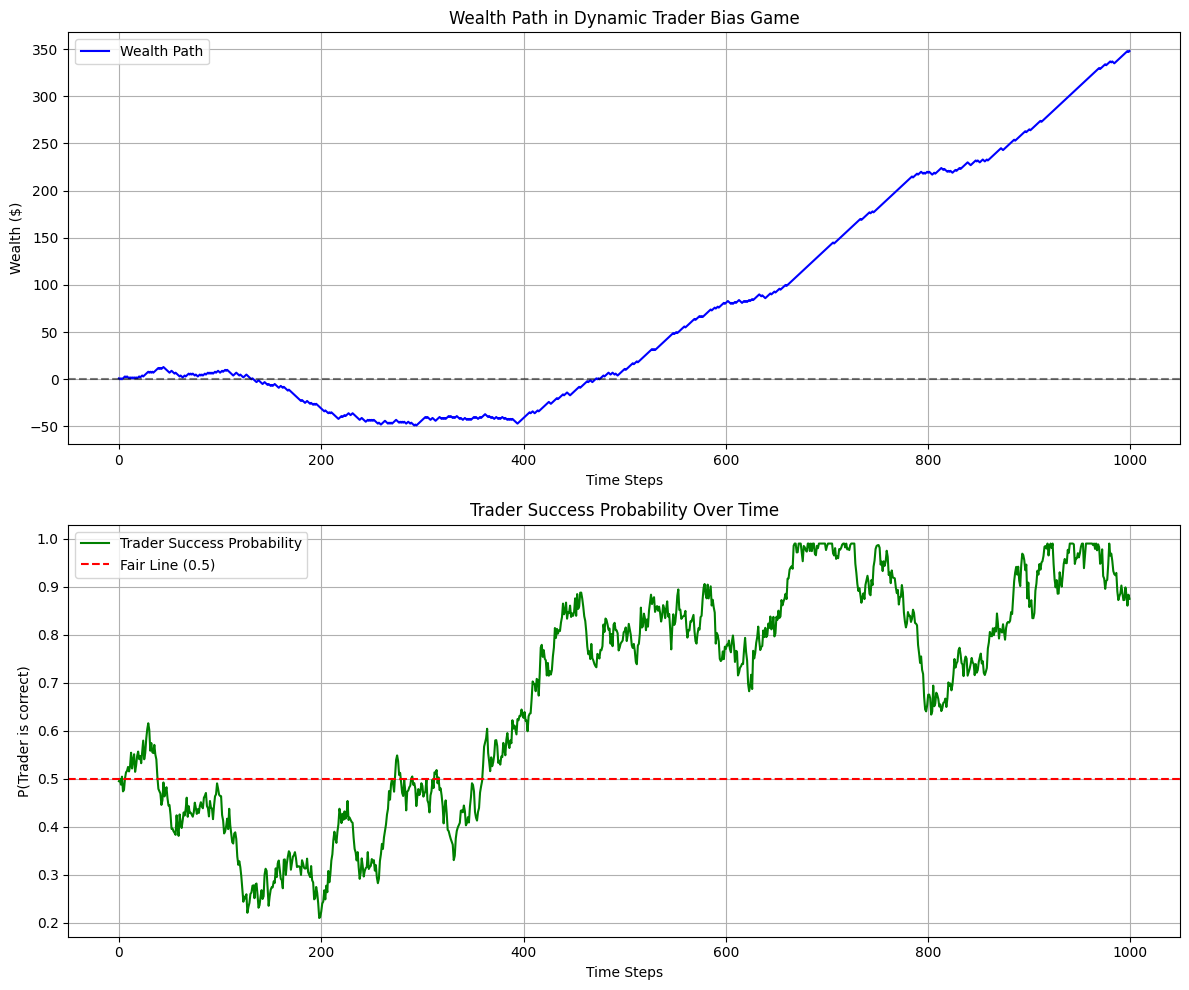

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def get_next_change_time(current_time):
    """Determine the next time the probability will change."""
    poisson_time = current_time + np.random.poisson(lam=20)
    geometric_time = current_time + np.random.geometric(p=0.05)
    exponential_time = current_time + np.floor(np.random.exponential(scale=20))
    return int(max(poisson_time, geometric_time, exponential_time))

def dynamic_trader_probability_game(n_steps):
    """
    Simulate a trader whose probability of being correct (aligned with the market) 
    changes dynamically over time using a stochastic process.
    The market itself is random (50/50), but the trader has a changing bias.
    """
    probabilities = np.zeros(n_steps)
    current_prob = 0.5
    next_change = 0

    # Parameters for probability dynamics
    drift = 0.001
    volatility = 0.02

    # Generate probability timeline for trader's win rate
    for t in range(n_steps):
        if t >= next_change:
            drift = np.random.normal(0, 0.002)
            next_change = get_next_change_time(t)

        random_shock = np.random.normal(0, volatility)
        current_prob += drift + random_shock
        current_prob = np.clip(current_prob, 0.01, 0.99)
        probabilities[t] = current_prob

    # Simulate static market: 50/50 chance of up or down
    market = np.random.binomial(n=1, p=0.5, size=n_steps)
    market_moves = 2 * market - 1  # +1 (up), -1 (down)

    # Trader makes decision: will they align with market?
    # With probability = probabilities[t], trader aligns with market
    aligned = np.random.random(n_steps) < probabilities
    outcomes = np.where(aligned, 1, -1)  # +1 = win (aligned), -1 = loss

    # Wealth over time
    wealth_path = np.cumsum(outcomes)

    return wealth_path, probabilities

# Run simulation
n_steps = 1000
wealth_path, probabilities = dynamic_trader_probability_game(n_steps)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot wealth path
ax1.plot(wealth_path, color='blue', label='Wealth Path')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Wealth Path in Dynamic Trader Bias Game')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probability changes
ax2.plot(probabilities, color='green', label='Trader Success Probability')
ax2.axhline(y=0.5, color='red', linestyle='--', label='Fair Line (0.5)')
ax2.set_title('Trader Success Probability Over Time')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('P(Trader is correct)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Conclusions

1. Trader Performance Tracks Bias
- The wealth curve strongly correlates with the trader’s probability of being correct.
- When the success probability > 0.5, the wealth grows.
- When < 0.5, the trader incurs losses.

This demonstrates that even subtle edge or disadvantage compounds significantly over time.

2. The Market is Not the Problem
- The market remains a fair 50/50.
- All fluctuations in wealth are entirely due to the trader's changing internal state — not external conditions.
- This underlines that psychological drift, inconsistency, or emotional misalignment can mimic randomness or worse.

3. Edge is Dynamic, Not Static
- Traditional models assume constant edge (or none).
- Here, edge is stochastic, demonstrating that traders may occasionally have an advantage, but it's volatile and can revert or disappear.

## Interpretation (for trading psychology / systems research)
The second experiment shows us:

1. Psychological Drift
- This model can represent a trader whose confidence, discipline, or cognitive clarity fluctuates.
- A drift into low-probability behavior could be caused by losses, overtrading, revenge trading, or fatigue.
- The model warns: **an intelligent system without stability is fragile.**

2. Dynamic Strategy Effectiveness
- Instead of viewing trading skill as static, this model embraces the idea of nonstationary performance.
- Real-world strategies degrade or improve over time — due to market regime changes, overfitting, or competition.
- This simulation offers a framework for modeling changing efficacy of strategies or signals.

3. Compounding Misalignment
- When the success rate dips below 50%, the damage compounds rapidly.
- This models situations like:
	- Following lagging indicators
	- Imitating others without understanding their concepts
	- Emotional decisions based on false narratives

## Academic Notes & Conceptual Connections:

#### Statistical / Mathematical Concepts
- Random Walk with Time-Varying Drift: The trader's wealth becomes a random walk where drift depends on P(success) − 0.5.
- Non-stationary Stochastic Processes: The decision bias evolves via arithmetic Brownian motion with Poisson/Geometric/Exponential intervals.
- Ergodicity Breaking: Time-average behavior may diverge from expectation if bias persists long enough in either direction.

### Behavioral Finance / Psychology
- Cognitive Bias Drift: Modeling how biases intensify or fade over time.
- Self-Sabotage Loops: Regions where the probability drops may resemble destructive trading spirals.
- Overconfidence and Underconfidence Cycles: Both visible in the probability oscillations.

**Adaptive Models vs Static Models: Shows why fixed strategies can fail in nonstationary environments.**

## Many naive traders

Now we run our second game not only for one trader (we want to see the change of probabilistic for single weath path), bot for many to check how this change works in general.

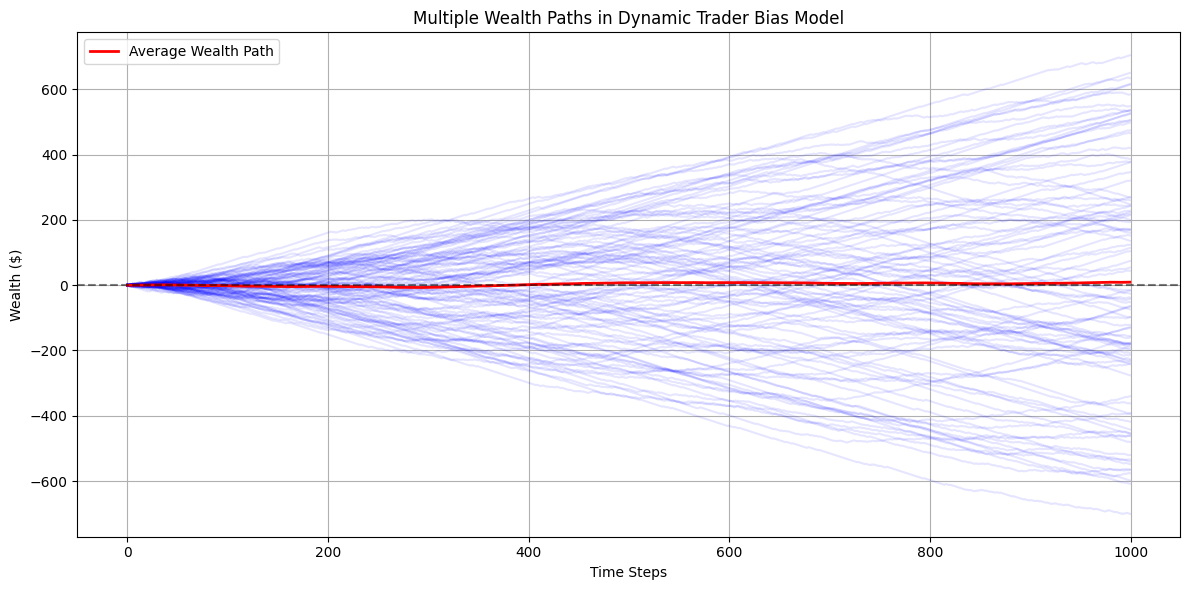

In [34]:
# Parameters
n_steps = 1000
n_sims = 100

wealth_paths = np.zeros((n_sims, n_steps))
probability_paths = np.zeros((n_sims, n_steps))

# Run many traders with independent stochastic win probabilities
for i in range(n_sims):
    w, p = dynamic_trader_probability_game(n_steps)
    wealth_paths[i] = w
    probability_paths[i] = p

plt.figure(figsize=(12, 6))

# Plot all paths (faint blue lines)
for i in range(n_sims):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot average path (bold line)
avg_wealth = np.mean(wealth_paths, axis=0)
plt.plot(avg_wealth, color='red', linewidth=2, label='Average Wealth Path')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Multiple Wealth Paths in Dynamic Trader Bias Model')
plt.xlabel('Time Steps')
plt.ylabel('Wealth ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusions

1. Zero Mean, Growing Variance
- The average wealth path (red line) remains close to zero throughout the simulation.
- This confirms that, on average, the traders are no better than random over time, despite momentary biases.
- However, the spread (variance) of outcomes increases rapidly, with some traders earning large profits and others incurring deep losses.

2. Random Bias Can Mimic Skill or Destruction
- Individual traders occasionally experience prolonged favorable bias, resulting in explosive gains — these traders may appear "skilled" in practice.
- Others drift toward long-term low probabilities of being correct, leading to significant losses.
- This mirrors real-world behavior: outperformance and underperformance can emerge purely by chance in nonstationary environments.

## Interpretation (for trading psychology / systems research)

1. Inconsistent Bias = Internal Noise
- The simulation represents traders who fluctuate in skill, confidence, or rationality — their probability of correctness is not fixed.
- This models emotional reactivity, regime misalignment, overconfidence cycles, or reaction to drawdowns.

2. Winner ≠ Skilled — They’re Just Lucky
- Traders who succeed in this simulation did not have a true edge — only a more favorable bias path by chance.
- This demonstrates how survivorship bias and overfitting may result from false assumptions of skill.

3. Population Drift = Strategy Drift
- This experiment can be interpreted as a testbed for strategy robustness in an ensemble setting:
	- If 100 variations of a strategy (with stochastic behavior) produce this pattern,
	- Then picking the top performer post-hoc is misleading and dangerous for capital allocation.
